In [ ]:
%pip install "roboquant[yahoo]" --quiet

from datetime import timedelta
from matplotlib import pyplot as plt
import roboquant as rq

print("roboquant", rq.__version__)
plt.rcParams["figure.figsize"] = (12,8)

Note: you may need to restart the kernel to use updated packages.
roboquant 1.6.0


# Feed
In order to run a strategy, we first need some data. In roboquant, data is provided by a `Feed`. 

In this example we'll use market data from Yahoo Finance.

In [ ]:
feed = rq.feeds.YahooFeed("TSLA", "AAPL", "F", "JPM", start_date="2010-01-01")

It is always good to inspect the data that we planning to use. So we plot the prices for the assets in the feed.
We can plot a single asset at a time, or use subplots.

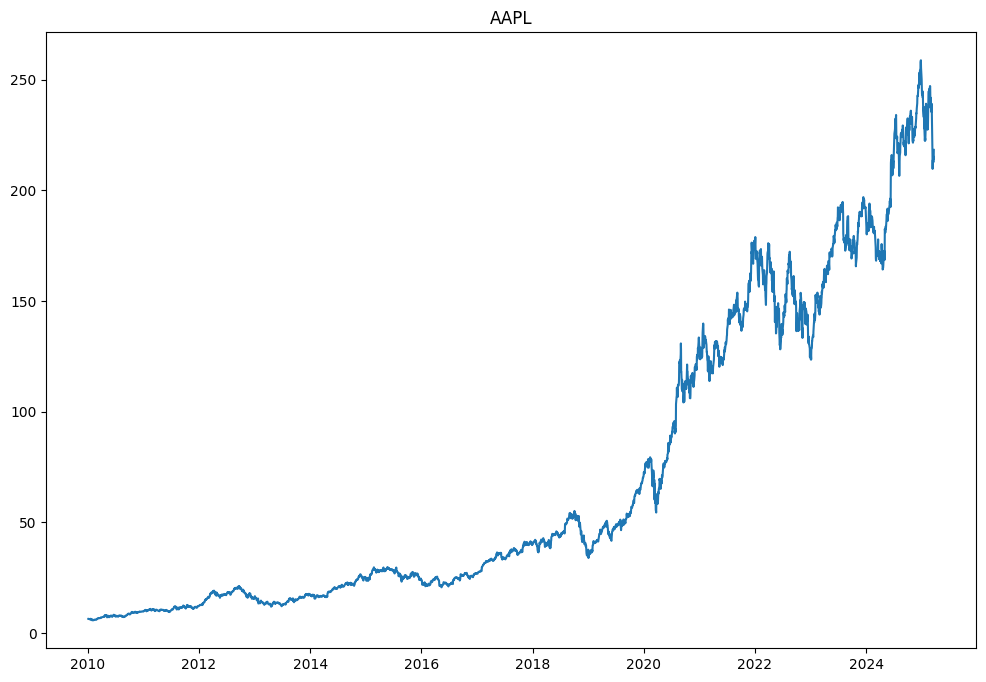

In [ ]:
apple = feed.get_asset("AAPL")
feed.plot(apple);

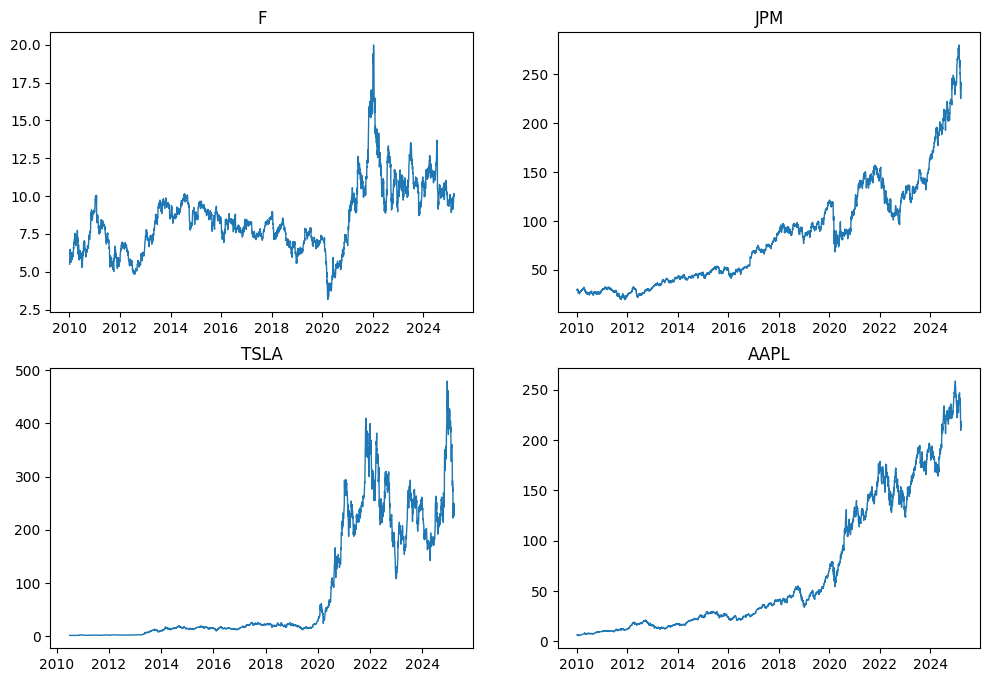

In [ ]:
for idx, asset in enumerate(feed.assets(), start=1):
    ax = plt.subplot(2,2,idx)
    feed.plot(asset, ax = ax, linewidth=1)

# Single back-test

We start with a simple backtest that will run once over all the available data in the feed. We'll also collect some P&L metrics so we have something to plot.

As our strategy we'll use the included EMA (Exponential Moving Average) crossover with its default values.

In [ ]:
strategy = rq.strategies.EMACrossover()
journal =  rq.journals.MetricsJournal.pnl()
rq.run(feed, strategy, journal = journal)

buying power : 1,044,615.93@USD
cash         : 1,044,615.93@USD
equity       : 1,099,616.43@USD
positions    : 5550@F
mkt value    : 55,000.50@USD
orders       : none
last update  : 2025-03-21 04:00:00+00:00

We can now plot the captured equity values to see how we have done. 

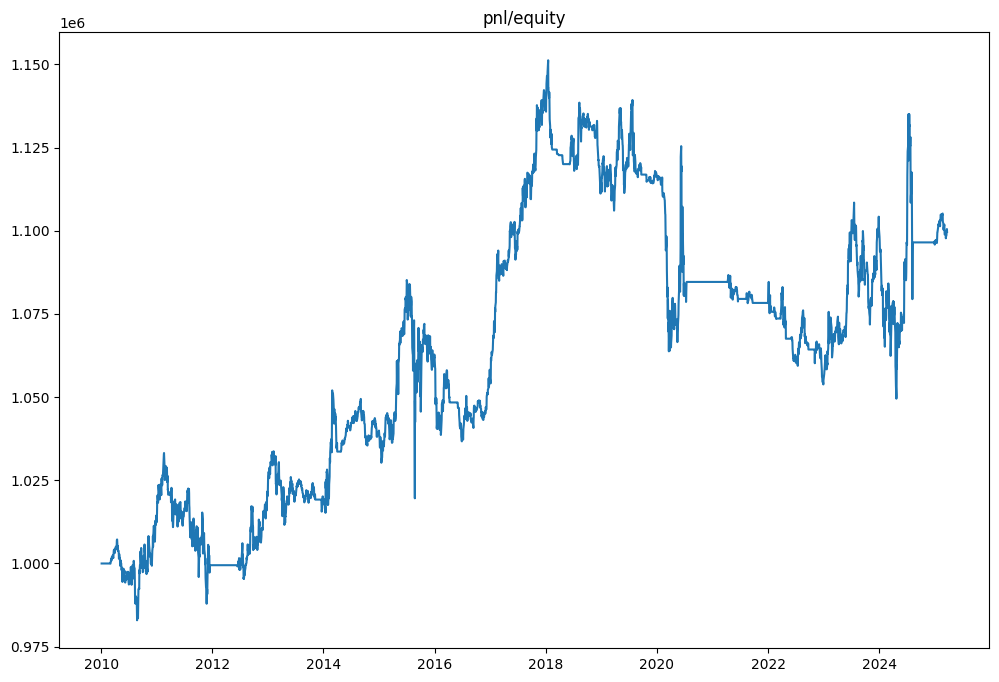

In [ ]:
journal.plot("pnl/equity");

Now lets plot all the metrics we captured during the run

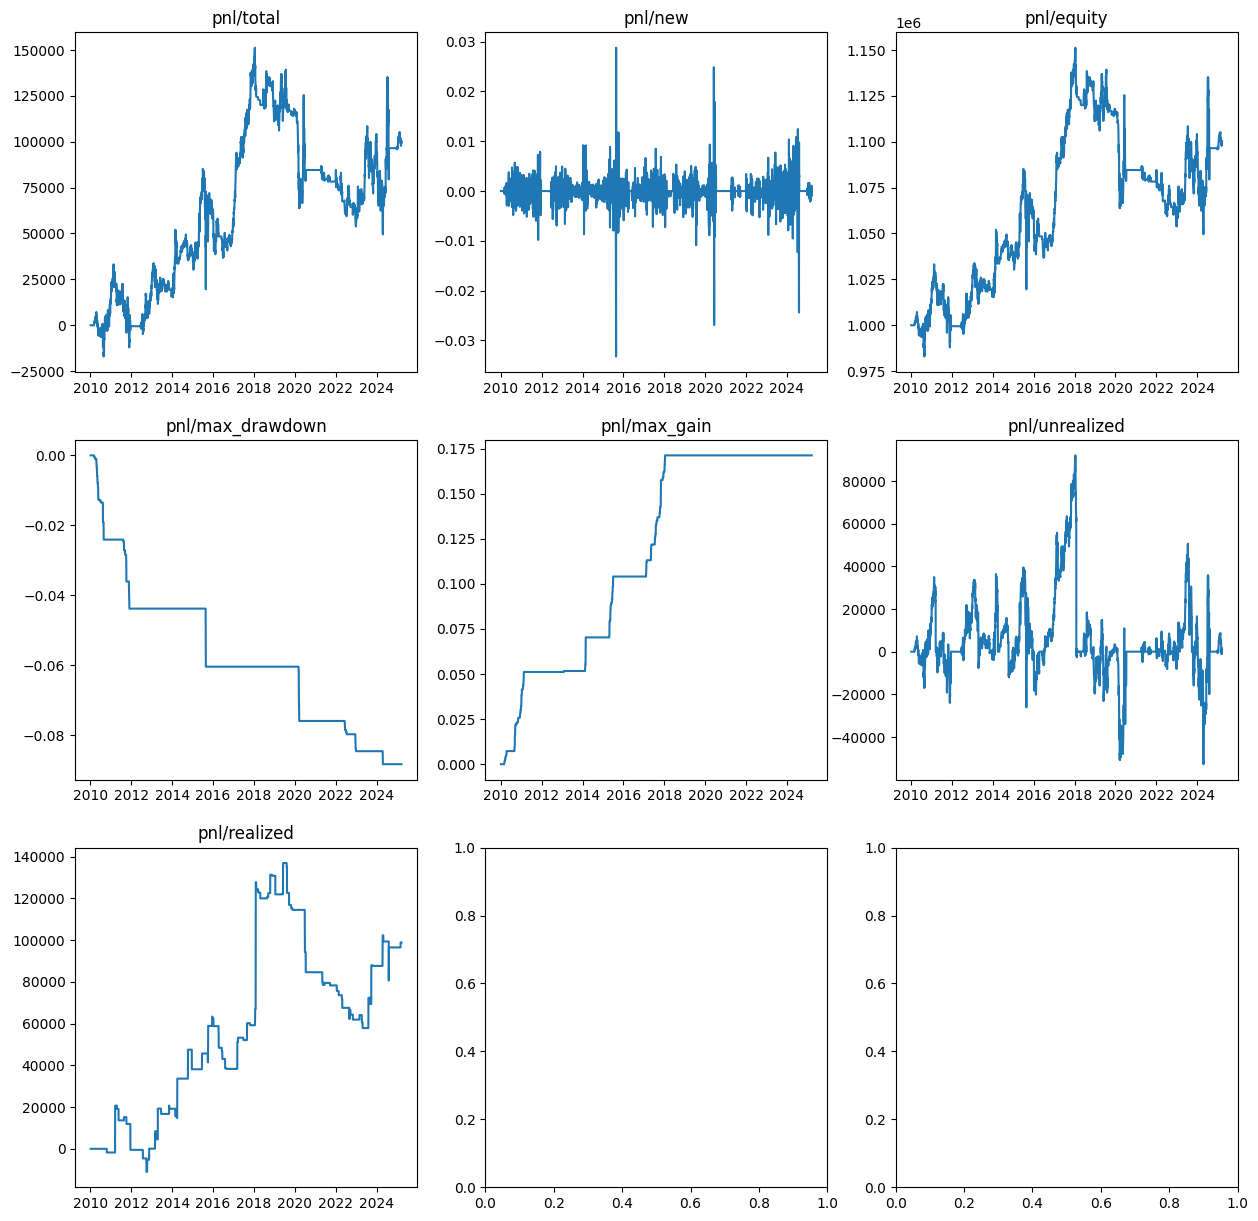

In [ ]:
metric_names = journal.get_metric_names()
_, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for ax, metric_name in zip(axs, metric_names):
    journal.plot(metric_name, ax=ax)

# Walk forward
Instead of a single backtest, we can also run a walk-forward.

We split the overall timeframe of the feed into 4 equal parts and run our backtest in a loop over each part.

At the end of each iteration we plot the equity. Since we don't call a `plt.show()` between the iterations, the results will be plotted on the same chart.

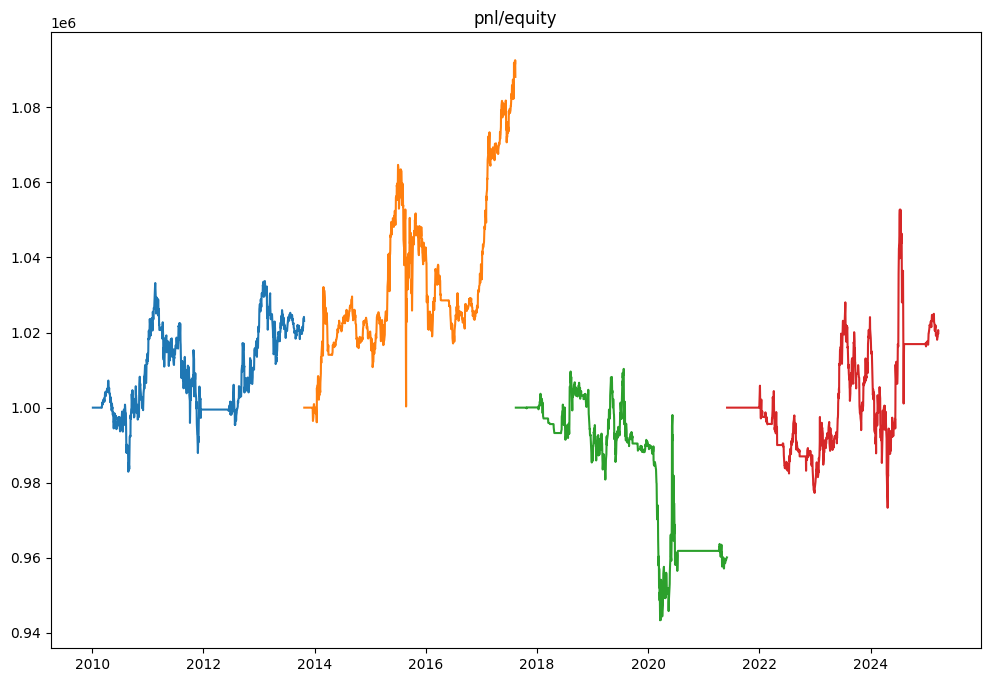

In [ ]:
def run_and_plot_equity(ax, timeframe, **kwargs):
    strategy = rq.strategies.EMACrossover()
    journal =  rq.journals.MetricsJournal.pnl()
    rq.run(feed, strategy, journal = journal, timeframe = timeframe)
    journal.plot("pnl/equity",ax = ax, **kwargs) 

_, ax = plt.subplots()
for timeframe in feed.timeframe().split(4):
    run_and_plot_equity(ax, timeframe)

# Monte Carlo simulation
We can even take it one step further, and run a Monte Carlo type of simulation over many more timeframes.

We'll sample 100 timeframes, each covering a 2-years period. And then we run our backtest again over each timeframe.

Notice that when we plot the equity this time we provide `plot_x=False`. This will result in each run being plottted as a sequence of steps and not in a timeline. Since there are roughly 250 trading days per year, two-years period implies about 500 steps.

We can now nicely compare the variance of our runs and might better understand the possible outcomes. 

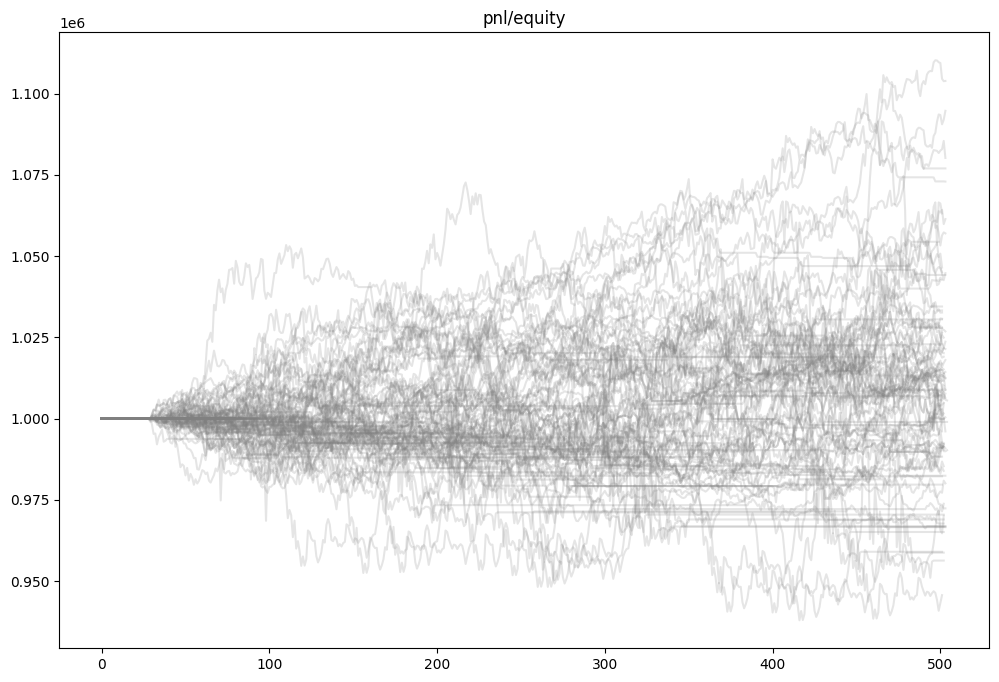

In [ ]:
two_year = timedelta(days=365*2)

# sample 100 timeframes, each of two-year period
timeframes = feed.timeframe().sample(two_year, 100)

_, ax = plt.subplots()
for timeframe in timeframes:
    run_and_plot_equity(ax, timeframe, plot_x=False, color="grey", alpha=0.2)